<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/simulate_fourier_slice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* simulate particles from arbitrary density map (e.g. published map on EMDB)

#Setup

In [1]:
!pip install mrcfile
import mrcfile

In [2]:
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/fourier.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/interp.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/twod.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/transfer.py
!wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py # needed for twod import
!pip install pyfftw
import coords, interp, fourier, twod, transfer
import importlib
importlib.reload(fourier)

--2021-04-10 19:24:53--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2603 (2.5K) [text/plain]
Saving to: ‘coords.py.2’

coords.py.2         100%[===================>]   2.54K  --.-KB/s    in 0s      

2021-04-10 19:24:53 (40.1 MB/s) - ‘coords.py.2’ saved [2603/2603]

--2021-04-10 19:24:53--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/dce31787838e61ec1143a462c11bf53d29108564/src/fourier.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response.

<module 'fourier' from '/content/fourier.py'>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def doplt(arr2d,cmap='gray',**kwargs):
  plt.imshow(arr2d,cmap=cmap,**kwargs)
from scipy.ndimage import map_coordinates
import numba

# Download map from EMDB
* use map from hetergenous ribosome paper. 
  * resolution ranges 3.7 - ~ 6 A
  * C1 symmetry
  * https://www.empiar.org/EMPIAR-10076
  * https://www.ebi.ac.uk/pdbe/entry/emdb/EMD-8450 3.7 A
  * https://www.ebi.ac.uk/pdbe/entry/emdb/EMD-8441 3.7 A

In [4]:
!wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-8450/map/emd_8450.map.gz

--2021-04-10 19:25:00--  ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-8450/map/emd_8450.map.gz
           => ‘emd_8450.map.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.197.74
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.197.74|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/emdb/structures/EMD-8450/map ... done.
==> SIZE emd_8450.map.gz ... 104651210
==> PASV ... done.    ==> RETR emd_8450.map.gz ... done.
Length: 104651210 (100M) (unauthoritative)

emd_8450.map.gz     100%[===================>]  99.80M  29.1MB/s    in 3.6s    

2021-04-10 19:25:05 (27.7 MB/s) - ‘emd_8450.map.gz’ saved [104651210]



In [5]:
!gunzip emd_8450.map.gz

^C


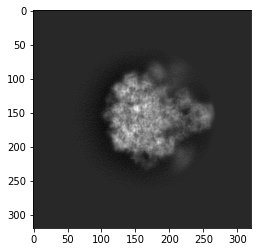

In [12]:
fname = 'emd_8450.map'
map_mrc = mrcfile.open(fname)
map_original = map_mrc.data
N = map_original.shape[0]
psize_original = map_mrc.voxel_size.item(0)[0]
psize = psize_original
doplt(map_original.sum(0))


# 3D Map
Now we simualte slices from an arbitrary map
* Zero pad the input volume
* 3D FFT the map
* Rotate (x,y,0) plane by desired rotation to get non-cartesian grid points
* Interpolate Fourier-transformed map at these points: this gives a 2D slice in Fourier space
* add CTF and noise if desired
* take 2D iFFT

## 3D FFT

In [58]:
map_f = fourier.do_fft(map_original)

## Rotate

In [59]:
N = map_f.shape[0]
xyz = coords.coords_n_by_d(np.arange(-N//2,N//2),d=3)
idx_z0 = xyz[:,-1] == 0 
xy0 = xyz[idx_z0]

In [98]:
n_particles=10000
np.random.seed(0)
qs = coords.get_random_quat(n_particles)
Rs = coords.quaternion_to_R(qs.T)
Rs.shape

(3, 3, 10000)

## CTFs

* If there are CTF aliasig issues, we can zero pad the initial volume (up sample)

Perhaps it’s more realistic to simulate things with a very uniform set of defoci (from ~0.75 - 3.5 um, for instance). In an experiment, even if you keep the scope set at the same defocus, there are variations in the sample height as you move around the grid (same as defocus), and this ends up changing the defocus. Some people change it up from area to area during screening. One questions experimentalists sometimes want to know is “what is a good range of defocus”? If the defocus is small, like 1 um, it’s harder to see the particles and pick them, but it doesn’t delocalize the information as much. Of course, in the end you need a bit of a range to fill out the zeros in the CTF…

With good alignment, the astigmatism should be low (elipticity of the pattern from difference between df1 and df2; df1=df2 implies zero astigmatism).

In [99]:
%%time
np.random.seed(0)
df_min, df_max = 15000, 20000
dfs = np.random.uniform(low=df_min,high=df_max,size=n_particles)
df_diff_min, df_diff_max = 100, 500
df_diff = np.random.uniform(low=df_diff_min,high=df_diff_max,size=n_particles)
df1s = dfs - df_diff/2
df2s = dfs + df_diff/2
df_ang_min, df_ang_max = 0, 360
df_ang_deg = np.random.uniform(low=df_ang_min,high=df_ang_max,size=n_particles)
CTFs = np.empty((n_particles,N,N))
kv=300
cs = 2.0
ac=0.1
freq_A_2d, angles_rad = transfer.ctf_freqs(N,psize,d=2)
for idx in range(n_particles):
  if idx % max(1,(n_particles//10)) == 0: print(idx)
  CTFs[idx] = transfer.eval_ctf(freq_A_2d, angles_rad, def1=df1s[idx], def2=df2s[idx], angast=df_ang_deg[idx], phase=0, kv=kv, ac=ac, cs=cs, bf=0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
CPU times: user 1min 28s, sys: 3.79 s, total: 1min 32s
Wall time: 1min 32s


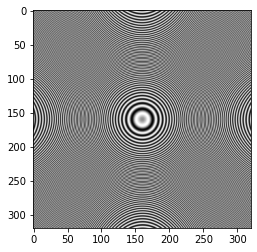

In [100]:
doplt(CTFs[1])

## Take slice (interpolate) and 2D-iFFT

In [ ]:
%%time
proj_f = np.zeros((n_particles,N,N),dtype=np.complex64)
snr = 1
for idx in range(n_particles):
  if idx % max(1,(n_particles//10)) == 0: print(idx)
  R = Rs[:,:,idx]
  xy0_rot = R.dot(xy0.T).T
  proj_f[idx] = (map_coordinates(map_f.real, xy0_rot.T + N//2,order=1).astype(np.complex64) + 1j*map_coordinates(map_f.imag, xy0_rot.T + N//2,order=1).astype(np.complex64)).reshape(N,N) # important to keep order=1 for speed. linear is good enough
  proj_f[idx] *= CTFs[idx] # can compute CTF on the fly if memory issues
  # proj_r[idx] = twod.do_ifft(proj_f[idx])

0
1000
2000


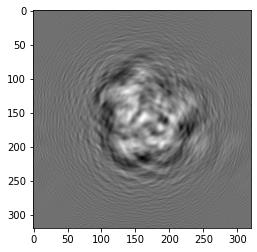

In [101]:
doplt(twod.do_ifft(proj_f[0]))

## Fourier crop
If desired we can Fourier crop to a different pixel size, for instance 128 vs 320. We loose resolution, but win on speedups
* We do the Fourier crop now, after the CTF, so that we have less aliasing issues from the rapid oscilations in the CTF at small box size and high defoci.

In [ ]:
N_crop = 128
i,f = N//2-N_crop//2, N//2+N_crop//2
proj_r = np.zeros((n_particles,N_crop,N_crop))
for idx in range(n_particles):
  proj_r[idx] = twod.do_ifft(proj_f[idx,i:f,i:f]).real
psize_crop = psize_original*N/N_crop
psize_crop

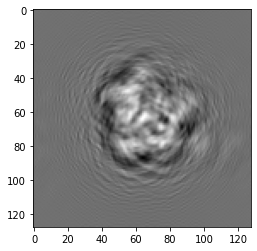

In [95]:
doplt(proj_r[0])

## Noise
* do after the croping, so the SNR corresponds to the final output particles
* while some authors define SNR as log S2/N2 ; or S2/N2 (cf. Penczek 2010), we define it here as |S|/|N| following cryoSPARC's simulate data job
  * Penczek, P. A. (2010). Image restoration in cryo-electron microscopy. Methods in Enzymology (1st ed., Vol. 482). Elsevier Inc. http://doi.org/10.1016/S0076-6879(10)82002-6

In [96]:
%%time
snr = 0.5
signal = np.std(proj_r)
noise = signal/snr
np.random.seed(0)
proj_r_noise = np.random.normal(loc=proj_r,scale=noise)

CPU times: user 5.34 s, sys: 111 ms, total: 5.45 s
Wall time: 5.43 s


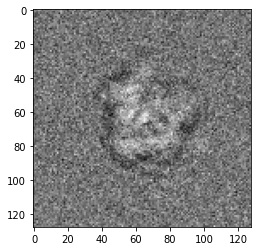

In [97]:
doplt(proj_r_noise[0])

# Write to mrc file

In [84]:
ofname = 'particles.mrc'
with mrcfile.new(ofname, overwrite=True) as mrc:
  mrc.set_data(proj_r_noise.astype(np.float32)) # see notes on float64 not supported https://mrcfile.readthedocs.io/en/latest/usage_guide.html

# Read from mrc file

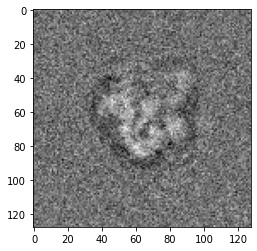

In [85]:
particles_mrc = mrcfile.open(ofname)
particles = particles_mrc.data
doplt(particles[0])

# Output metadata

In [86]:
df = pd.DataFrame({'df1_A':df1s,'df2_A':df2s,'df_ang_deg':df_ang_deg,'kev':kv,'ac':ac,'cs_mm':cs,
              'rotation_quaternion':[np.array2string(q) for q in qs]
            })
df.to_csv('metadata.tsv',sep='\t')

In [87]:
!cat metadata.tsv

	df1_A	df2_A	df_ang_deg	kev	ac	cs_mm	rotation_quaternion
0	17575.491465480394	17912.643573792855	292.14664942387793	300	0.1	2.0	[0.5389707  0.40087041 0.70858764 0.21614129]
1	18523.934092730877	18627.959570993316	171.39023494856352	300	0.1	2.0	[0.00843602 0.53360985 0.57511069 0.62002989]
2	17868.651641186774	18158.982119529664	188.33615639714728	300	0.1	2.0	[0.42842606 0.46226371 0.56858322 0.52865537]
3	17532.661836796276	17916.169993172694	90.18741111018429	300	0.1	2.0	[0.6052561  0.29796287 0.28303996 0.68174157]
4	17059.478910289705	17177.06908309934	217.81548605177005	300	0.1	2.0	[0.05239935 0.75736352 0.5295933  0.37839891]
5	18003.566268728537	18455.374861938028	109.04573112114062	300	0.1	2.0	[0.5844437  0.11194395 0.36812455 0.71440775]
6	17033.919772986326	17341.952339640597	207.82224523547353	300	0.1	2.0	[0.54674974 0.51330061 0.52095604 0.40766655]
7	19402.732794245258	19514.99721357554	61.08412160666515	300	0.1	2.0	[0.01583823 0.32859725 0.24872459 0.91099346]
8	19723.431